# Hungaroring Hamilton Race

**Goal**  
Explore Hamilton's grid position during 2021 Hungarian GP  

**Background**  
Traditionally, F1 races can be quite boring due to Lewis Hamilton's dominance. This season less thanks to Verstappen's increasing skill in the Red Bull car.  
The Hungarian GP this year was especially exciting because of the poor pitstop strategy for Hamilton, putting him on the Hard tyres on lap 4 just after the crash and red flag. This lead to him having to fight his way back into the points, and a brilliant 16 laps stuck behind his former *teammate* from 2007, Alonso.

**Dataset**  
Our data comes from the Ergast Developer API which "provides a historical record of motor racing data for non-commercial purposes".  
[Link to API](http://ergast.com/mrd/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests

Import hamilton's Hungarian GP lap times

In [2]:
url = 'https://ergast.com/api/f1/2021/11/drivers/hamilton/laps.json?limit=1000'

r = requests.get(url)
assert r.status_code == 200, 'Cannot connect to Ergast API'

drivers = r.json()
result = pd.DataFrame(drivers["MRData"]["RaceTable"]['Races'][0]['Laps'])

In [3]:
result.head()

,number,Timings
0,1,"[{'driverId': 'hamilton', 'position': '1', 'ti..."
1,2,"[{'driverId': 'hamilton', 'position': '1', 'ti..."
2,3,"[{'driverId': 'hamilton', 'position': '13', 't..."
3,4,"[{'driverId': 'hamilton', 'position': '1', 'ti..."
4,5,"[{'driverId': 'hamilton', 'position': '14', 't..."


In [4]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   number   70 non-null     object
 1   Timings  70 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


70 entries for 70 laps of the race.

`number`:  lap number (1-70)
`Timings`: list containing a dict (driverId, position, time)

## Data cleaning

There's a couple necessary steps to get our data into a working format:
- rename `number` column to `lap`
- extract `driverId`, `position`, `time` from the dict inside of `Timings`
- set dtypes of columns

Renaming `number` column

In [5]:
result = result.rename(columns={'number': 'lap'})

Extracting columns from `Timings`:

In [6]:
result[['Timings']] = pd.DataFrame(result.Timings.tolist(), index=result.index)
result[['driverId','position','time']] = pd.DataFrame(result.Timings.tolist(), index=result.index)

In [7]:
# drop Timings column once data is extracted
result.drop(columns=['Timings'], axis=1, inplace=True)

Set `lap` and `position` to int

In [8]:
result = result.astype({"lap": int, "position": int})

In [9]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lap       70 non-null     int32 
 1   driverId  70 non-null     object
 2   position  70 non-null     int32 
 3   time      70 non-null     object
dtypes: int32(2), object(2)
memory usage: 1.8+ KB


In [10]:
result.head()

,lap,driverId,position,time
0,1,hamilton,1,1:58.069
1,2,hamilton,1,2:49.020
2,3,hamilton,13,26:46.873
3,4,hamilton,1,1:49.712
4,5,hamilton,14,1:43.232


Lap 3 has an outlier position (13), compared to the values before and after. It corresponds to the lap of the crash and red flag.

Having checked the race replay, Hamilton doesn't drop out of p1 until lap 5, so we'll need to correct that.

In [11]:
result.loc[2, 'position'] = 1

## Analysis

**Q:** How many laps did hamilton spend in each position?

In [12]:
result['position'].value_counts(ascending=False)

5     25
4     10
13     6
14     5
1      4
3      4
7      4
11     4
8      3
9      2
6      1
10     1
12     1
Name: position, dtype: int64

- 25 laps spent in p5 = 35.7% of race  
- 35 laps in p4/p5 = 50% of race

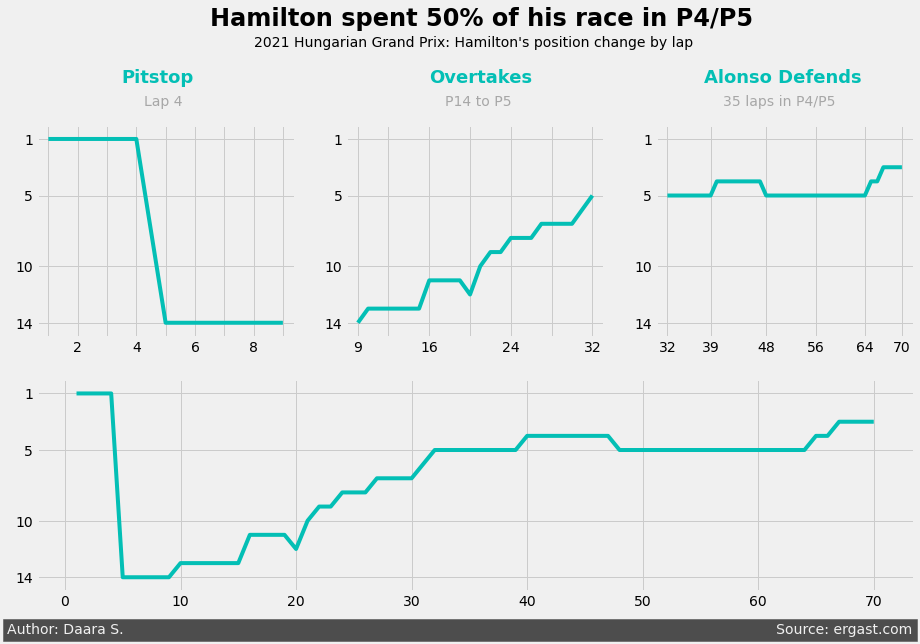

In [13]:
# FiveThirtyEight style
import matplotlib.style as style
style.use('fivethirtyeight')

# subplots
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,1,2)
axes = [ax1, ax2, ax3, ax4]

# subplot modifications
for ax in axes:
    ax.invert_yaxis()
    ax.set_ylim([15,0])
    ax.set_yticks([14, 10, 5, 1])
    
    
# Ax1: pit-stop
ax1.plot(result['lap'][:9], result['position'][:9], color='#03BFB5')

ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax1.set_xticklabels(['', '2', '','4','','6','','8',''])

ax1.text(3.5, -3, 'Pitstop', fontsize=18, weight='bold', color='#03BFB5')
ax1.text(4.25, -1.35, 'Lap 4', alpha=0.3)


# Ax2: Overtakes
ax2.plot(result['lap'][8:32], result['position'][8:32], color='#03BFB5')

ax2.set_xticks([9, 12, 16, 20, 24, 28, 32])  
ax2.set_xticklabels(['9', '', '16', '', '24', '', '32'])

ax2.text(16, -3, 'Overtakes', fontsize=18, weight='bold', color='#03BFB5')
ax2.text(17.5, -1.35, 'P14 to P5', alpha=0.3)


# Ax3: Alonso Defends
ax3.plot(result['lap'][31:], result['position'][31:], color='#03BFB5')

ax3.set_xticks([32, 39, 48, 56, 64, 70])
ax3.text(38, -3, 'Alonso Defends', fontsize=18, weight='bold', color='#03BFB5')

ax3.text(41, -1.35, '35 laps in P4/P5', alpha=0.3)

# Ax4: Full race
ax4.plot(result['lap'], result['position'], color='#03BFB5')

# Title and subtitle
ax1.text(6.5, -7, 'Hamilton spent 50% of his race in P4/P5', fontsize=24, weight='bold')
ax1.text(8, -5.5, '2021 Hungarian Grand Prix: Hamilton\'s position change by lap', fontsize=14)

# Signature
ax4.text(-5, 18, 'Author: Daara S.' + ' '*145 + 'Source: ergast.com',
         color = '#f0f0f0', backgroundcolor = '#4d4d4d', size=14)

plt.show()